In [1]:
# Install dependencies
!pip install -q SimpleITK
!pip install -q nibabel scikit-image gdown
!git clone https://github.com/uncbiag/uniGradICON.git
!pip install ./uniGradICON


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 46.6 MB/s eta 0:00:00
Cloning into 'uniGradICON'...
remote: Enumerating objects: 536, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 536 (delta 87), reused 83 (delta 40), pack-reused 352 (from 1)
Receiving objects: 100% (536/536), 11.00 MiB | 14.78 MiB/s, done.
Resolving deltas: 100% (242/242), done.
Processing ./uniGradICON
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.

## 2. Import Libraries

In [3]:
import os
import SimpleITK as sitk
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm


## 3. Preprocessing Utilities

In [4]:
# Normalize volume
def normalize(img):
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

# Resize and save MHD to NIfTI
def convert_mhd_to_nifti(mhd_path, out_path, shape=(160, 192, 144)):
    img = sitk.ReadImage(mhd_path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)
    arr = normalize(arr)
    arr = resize(arr, shape, preserve_range=True)
    nib.save(nib.Nifti1Image(arr, np.eye(4)), out_path)
    print(f"Saved: {out_path}")


## 4. Single Patient Registration


In [6]:
# Paths

ct_mhd = "/content/drive/MyDrive/Data/rire/109/ct/patient_109_ct.mhd"
mri_mhd = "/content/drive/MyDrive/Data/rire/109/mr_T1/patient_109_mr_T1.mhd"

# replace with
# ct_mhd = "dataset/rire/109/ct/patient_109_ct.mhd"
# mri_mhd = "dataset/rire/109/mr_T1/patient_109_mr_T1.mhd"

# Target shape
target_shape = (160, 192, 144)

# Output folders
os.makedirs("data_rire", exist_ok=True)

# Preprocessing
convert_mhd_to_nifti(ct_mhd, "data_rire/fixed.nii.gz", target_shape)
convert_mhd_to_nifti(mri_mhd, "data_rire/moving.nii.gz", target_shape)

# Run uniGradICON registration
!unigradicon-register \
  --fixed=data_rire/fixed.nii.gz \
  --moving=data_rire/moving.nii.gz \
  --fixed_modality=ct \
  --moving_modality=mri \
  --transform_out=trans.hdf5 \
  --warped_moving_out=warped.nii.gz \
  --io_iterations None


Saved: data_rire/fixed.nii.gz
Saved: data_rire/moving.nii.gz


## 5. Visualization of Single Patient Results


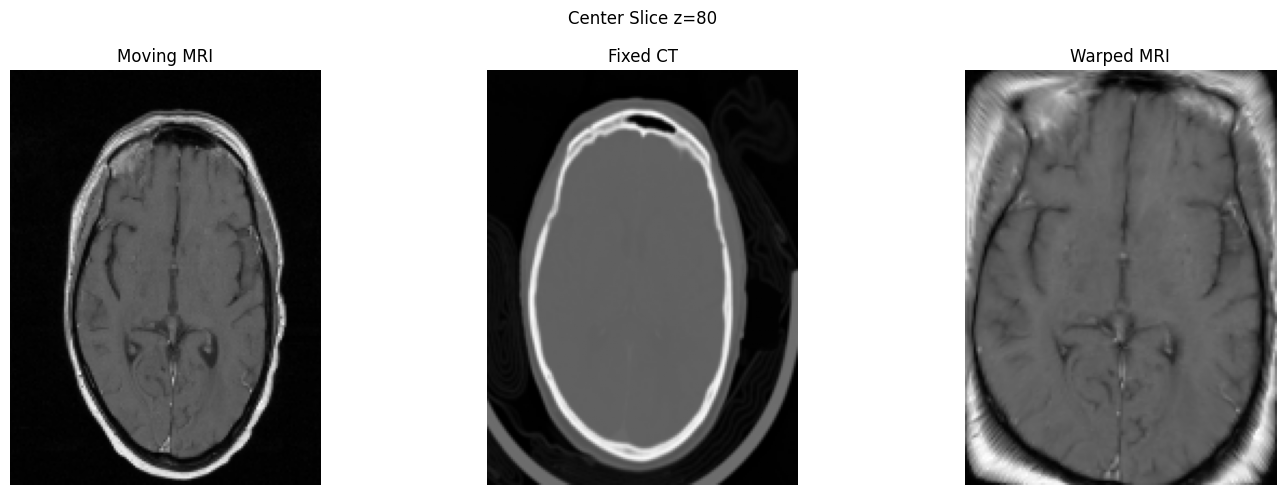

In [7]:
# Load volumes
fixed = nib.load("data_rire/fixed.nii.gz").get_fdata()
moving = nib.load("data_rire/moving.nii.gz").get_fdata()
warped = nib.load("warped.nii.gz").get_fdata()

# Plot center slice
z = fixed.shape[0] // 2
plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip([moving[z], fixed[z], warped[z]], ['Moving MRI', 'Fixed CT', 'Warped MRI'])):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.suptitle(f"Center Slice z={z}")
plt.tight_layout()
plt.show()


## 6. Metric Computation for Single Patient

In [8]:
# Normalize for evaluation
fixed_norm = normalize(fixed[z])
warped_norm = normalize(warped[z])

# SSIM and MSE
ssim_val = ssim(fixed_norm, warped_norm, data_range=1.0)
mse_val = mean_squared_error(fixed_norm.flatten(), warped_norm.flatten())

print(f"SSIM: {ssim_val:.4f}")
print(f"MSE : {mse_val:.6f}")


SSIM: 0.2555
MSE : 0.097027


## 7. Full Dataset Registration

In [9]:
# Configs
base_dir = "/content/drive/MyDrive/Data/rire"
work_dir = "/content/data_rire"

# replce with
# base_dir = "dataset/rire"
# work_dir = "data_rire"


save_dir = "unigradicon_cli_results"
vis_dir = os.path.join(save_dir, "visuals")
csv_path = os.path.join(save_dir, "metrics.csv")
target_shape = (160, 192, 144)

# Setup
os.makedirs(work_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)
os.makedirs(vis_dir, exist_ok=True)

results = []

def extract_center_slice(vol, axis=0):
    return np.take(vol, vol.shape[axis] // 2, axis=axis)

# Loop over patients
for pid in tqdm(sorted(os.listdir(base_dir))):
    if not pid.isdigit():
        continue

    print(f"Processing patient {pid}")

    ct_path = os.path.join(base_dir, pid, "ct", f"patient_{pid}_ct.mhd")
    mri_path = os.path.join(base_dir, pid, "mr_T1", f"patient_{pid}_mr_T1.mhd")

    if not os.path.exists(ct_path) or not os.path.exists(mri_path):
        print(f"Missing data for patient {pid}")
        continue

    # Preprocessing
    fixed_nii = os.path.join(work_dir, "fixed.nii.gz")
    moving_nii = os.path.join(work_dir, "moving.nii.gz")
    convert_mhd_to_nifti(ct_path, fixed_nii, target_shape)
    convert_mhd_to_nifti(mri_path, moving_nii, target_shape)

    # Run registration
    !unigradicon-register \
      --fixed={fixed_nii} \
      --moving={moving_nii} \
      --fixed_modality=ct \
      --moving_modality=mri \
      --transform_out={os.path.join(work_dir, "trans.hdf5")} \
      --warped_moving_out={os.path.join(work_dir, "warped.nii.gz")} \
      --io_iterations None

    # Load results
    try:
        fixed = nib.load(fixed_nii).get_fdata()
        warped = nib.load(os.path.join(work_dir, "warped.nii.gz")).get_fdata()
    except Exception as e:
        print(f"Failed for patient {pid}: {e}")
        continue

    # Extract center slice
    fixed_slice = extract_center_slice(fixed)
    warped_slice = extract_center_slice(warped)

    # Evaluate
    ssim_val = ssim(fixed_slice, warped_slice, data_range=1.0)
    mse_val = mean_squared_error(fixed_slice.flatten(), warped_slice.flatten())

    # Save visualization
    vis_path = os.path.join(vis_dir, f"patient_{pid}.png")
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(
        [fixed_slice, warped_slice],
        ["Fixed (CT)", "Warped MRI→CT"]
    )):
        plt.subplot(1, 2, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.suptitle(f"Patient {pid} | SSIM: {ssim_val:.4f} | MSE: {mse_val:.4f}")
    plt.tight_layout()
    plt.savefig(vis_path)
    plt.close()

    results.append({
        "patient": pid,
        "ssim": ssim_val,
        "mse": mse_val
    })

# Save results CSV
df = pd.DataFrame(results)
df.to_csv(csv_path, index=False)
print(f"Saved metrics to {csv_path}")


  0%|          | 0/14 [00:00<?, ?it/s]

Processing patient 02
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


  7%|▋         | 1/14 [00:30<06:38, 30.65s/it]

Processing patient 03
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 14%|█▍        | 2/14 [01:01<06:06, 30.56s/it]

Processing patient 04
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 21%|██▏       | 3/14 [01:31<05:33, 30.36s/it]

Processing patient 05
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 29%|██▊       | 4/14 [02:01<05:03, 30.39s/it]

Processing patient 06
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 36%|███▌      | 5/14 [02:31<04:32, 30.32s/it]

Processing patient 07
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 43%|████▎     | 6/14 [03:02<04:04, 30.55s/it]

Processing patient 101
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 50%|█████     | 7/14 [03:33<03:34, 30.65s/it]

Processing patient 102
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 57%|█████▋    | 8/14 [04:04<03:04, 30.71s/it]

Processing patient 103
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 64%|██████▍   | 9/14 [04:35<02:33, 30.69s/it]

Processing patient 104
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 71%|███████▏  | 10/14 [05:06<02:03, 30.80s/it]

Processing patient 105
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 79%|███████▊  | 11/14 [05:36<01:32, 30.72s/it]

Processing patient 107
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 86%|████████▌ | 12/14 [06:07<01:01, 30.64s/it]

Processing patient 108
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


 93%|█████████▎| 13/14 [06:37<00:30, 30.60s/it]

Processing patient 109
Saved: /content/data_rire/fixed.nii.gz
Saved: /content/data_rire/moving.nii.gz


100%|██████████| 14/14 [07:06<00:00, 30.46s/it]

Saved metrics to unigradicon_cli_results/metrics.csv
